**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 2 Clustering Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

The dataset coming from the data preparation task is saved on github.

In [ ]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


**Load the players' profile dataset**

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000


In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


##**Choosing the features and normalization**

Before we apply any clustering algorithm we need to choose the features that we think are the best at describing the players. Then we apply normalization on such features.

We decided to consider mainly the percentages since they describe better the player's attitude on the field (albeit they aren't as much as robust). Since there are a lot of feature, with many of them unrelated, we decided to build three different dataframe to work on during the clustering analysis plus a fourth one which contains all the features.

In [ ]:
# retrieve only the numerical features
df_players_numerical = df_players.select_dtypes(["int32", "Int32", "float64"])

# build the dataframe for the clustering analysis
df_clustering_0 = df_players_numerical[["t_won", "p_wins", "rank"]]  # cluster about the strenght of a player
df_clustering_1 = df_players_numerical[["p_w_Hard", "p_w_Clay", "p_w_Grass"]]  # cluster about the performance
df_clustering_2 = df_players_numerical[["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won", "mean_sv_points"]]  # cluster about the playstyle of the player
df_clustering_3 = df_players_numerical  # cluster for all the feature
df_clusters = [df_clustering_0, df_clustering_1, df_clustering_2, df_clustering_3]

We decided to normalize such features with their z-score by using the scikit-learn StandardScaler.

In [ ]:
scaler = StandardScaler()  # z-score scaler
x_clusters = []
df_clusters_scaled = []
for df_clustering in df_clusters:
    x = scaler.fit_transform(df_clustering.values)
    df_clustering_scaled = pd.DataFrame(x, columns=df_clustering.columns, index=df_clustering.index)
    x_clusters.append(x)
    df_clusters_scaled.append(df_clustering_scaled)

df_clusters_scaled[0]

,t_won,p_wins,rank
0,7.367218,2.014899,-1.130862
8,-0.439752,0.084832,1.012741
13,-0.439752,0.619264,-0.276472
14,-0.439752,-1.125868,-0.512955
15,-0.439752,-0.519343,0.768630
...,...,...,...
4253,-0.439752,0.685872,0.961885
4254,-0.439752,-1.386815,4.504044
4255,-0.439752,0.210995,0.313464
4256,-0.439752,-0.261530,0.285493


Let's plot the first three dataframes.

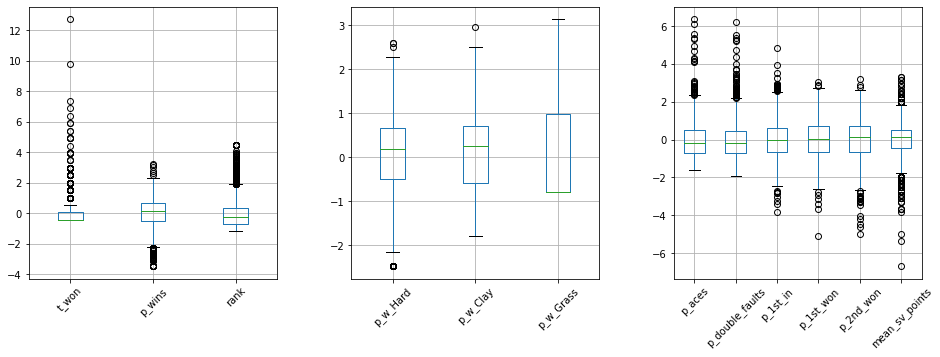

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
df_clusters_scaled[0].boxplot(list(df_clusters_scaled[0].columns), rot=45, ax=ax0)
df_clusters_scaled[1].boxplot(list(df_clusters_scaled[1].columns), rot=45, ax=ax1)
df_clusters_scaled[2].boxplot(list(df_clusters_scaled[2].columns), rot=45, ax=ax2)
fig.subplots_adjust(wspace=0.3)

Now the last dataframe, the one that contains all the features.

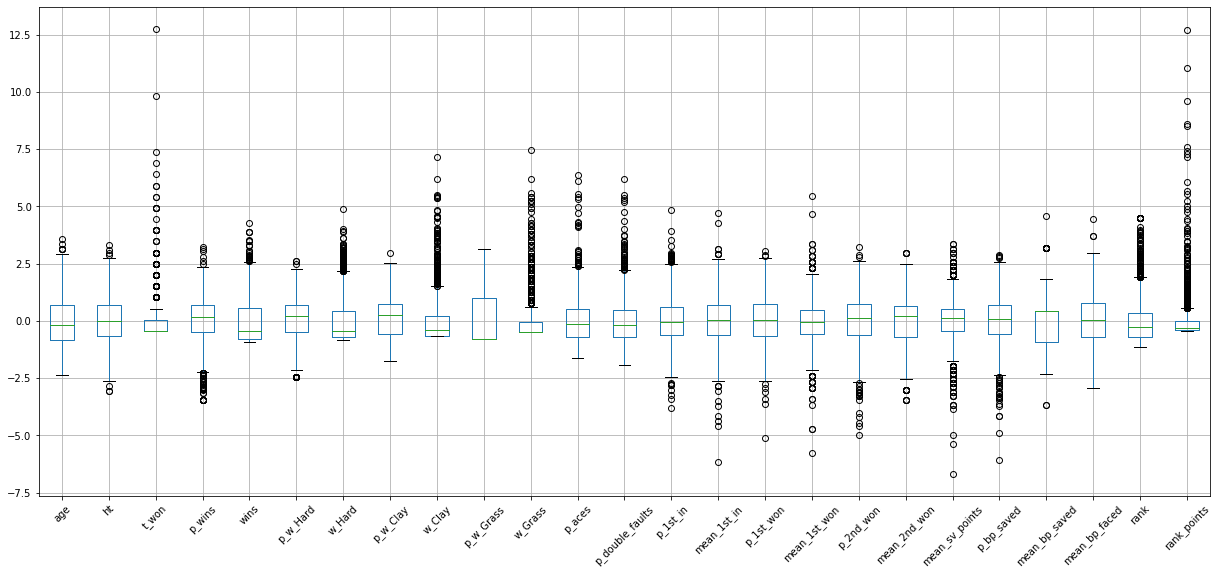

In [ ]:
df_clusters_scaled[3].boxplot(list(df_clusters_scaled[3].columns), rot=45, figsize=(21, 9));

###**PCA, forse**

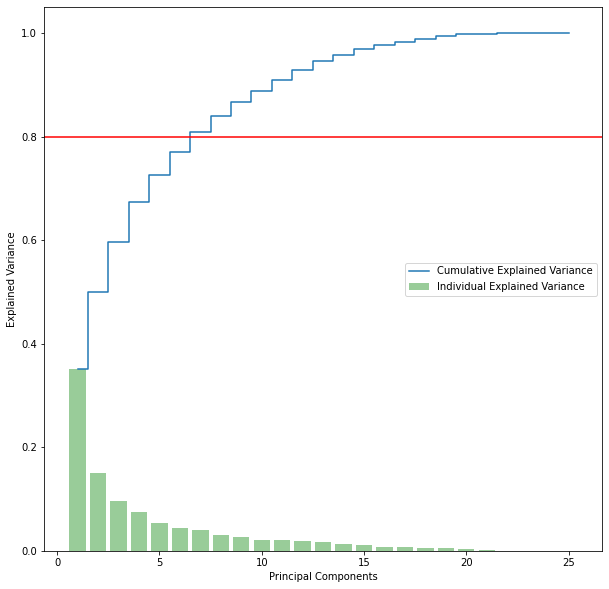

In [ ]:
pca = PCA()
pca.fit(df_clustering_scaled)
plt.figure(figsize=(10, 10))
plt.step(range(1, df_clustering.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, df_clustering_scaled.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='-')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='center right');

In [ ]:
n_pc = 2 # number of first principal components to analyze
pca = PCA(n_components=n_pc)
pca.fit(x)

F = abs(pca.components_) # F[i][j] is the proportion of the feature j in the the i-th principal components
v = pca.explained_variance_ratio_ # v[i] is the explained variance of the i-th principal component

feature_variability = v.dot(F) # weighted sum of the importance of a feature respect the principal components

dic = {df_clustering_scaled.columns[i]: feature_variability[i] for i in range(len(feature_variability))}
df_var = pd.DataFrame(dic.items())
df_var.columns = ['feature', 'variability']
df_var.sort_values(by=['variability'], ascending=False, inplace=True)
df_var

,feature,variability
15,p_1st_won,0.133020
4,wins,0.122143
22,mean_bp_faced,0.115308
11,p_aces,0.113544
17,p_2nd_won,0.113122
6,w_Hard,0.110582
20,p_bp_saved,0.108101
18,mean_2nd_won,0.105218
3,p_wins,0.104648
2,t_won,0.103476


## **K-means**

We run the k-means algorithm and we chose the best number of clusters based on the three indicators (the ones which we've seen during lesson), then we analize the results obtained.

**Indicators:**

*   **SSE Score** (Inertia): Sum of squared error
*   **Silhouette Score**: It combines both cohesion and separation. Cluster cohesion measures how closely related are objects in a cluster. Typically between 0 and 1, the closer to 1 the better.
*   **Davies Bouldin Score**: It is defined as a ratio of within cluster scatter and the between cluster separation. (Positive indicator, lower value closer to 0 is better).

In [ ]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

Calculate the SSE, Silhoutte and Davies-Bouldin score for each dataframe.

In [ ]:
sse_clusters = []
sil_clusters = []
davies_clusters = []
for i, x_cluster in enumerate(x_clusters):
    # print(x_cluster)
    sse, sil, davies_bouldin = k_means(x_cluster, i, 20)
    sse_clusters.append(sse)
    sil_clusters.append(sil)
    davies_clusters.append(davies_bouldin)

Dataframe 0, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 1, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 2, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 3, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the indicators values for each k.

In [ ]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

Let's focus on the first dataframe for now, the one with ["t_won", "p_wins", "rank"].

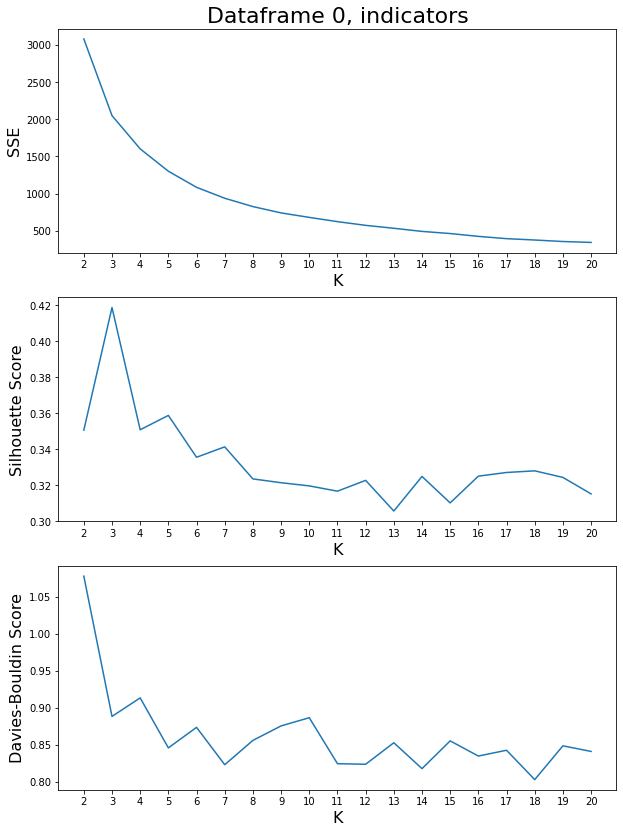

In [ ]:
plot_indicators(0, 20, sse_clusters[0], sil_clusters[0], davies_clusters[0])

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 3, we proceed with our analysis.

In [ ]:
k = 3  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[0])
print("SSE:",sse_clusters[0][k-2]," - SILHOUETTE:",sil_clusters[0][k-2])

SSE: 2050.105646746996  - SILHOUETTE: 0.4186592739338631


Let's see how many players are in each cluster.

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 375, 1: 214, 2: 1011}


**Using Similarity Matrix for Cluster Validation**: if we have well-separated clusters, then the similarity matrix should be
roughly block-diagonal 

In [ ]:
def plot_similarity_heatmap(df, labels):
    df = pd.DataFrame(df)
    df['cluster'] = labels
    columns = df.columns[0:-1]
    df.sort_values(by='cluster', ascending=False, inplace=True)
    dist = euclidean_distances(df.loc[:, columns], df.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(12,8))
    sn.heatmap(sim, ax=ax, cmap='coolwarm')

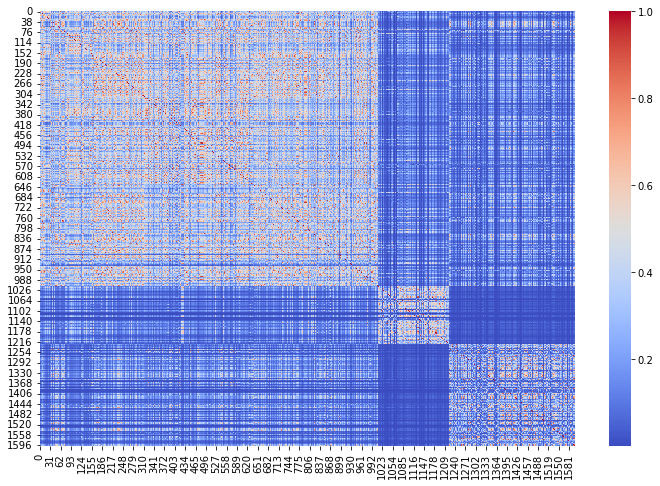

In [ ]:
clusters_players = kmeans.labels_
plot_similarity_heatmap(df_clusters_scaled[0], clusters_players)

### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Let's take the players with the most tourneys won.

In [ ]:
df_players[df_players["t_won"]==df_players["t_won"].max()]

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
255,novak djokovic,M,34,SRB,188,R,27,85.45,282,85.86,164,82.18,83,92.11,35,6.84,3.23,65.46,51,74.58,38,55.49,14,77,65.65,3,4,1,12113,"[28,34]","[181,190]",top 10


We now plot the clusters using the PCA.

Text(255    6.630078
Name: PC_1, dtype: float64, 255    8.452943
Name: PC_2, dtype: float64, 'novak djokovic')

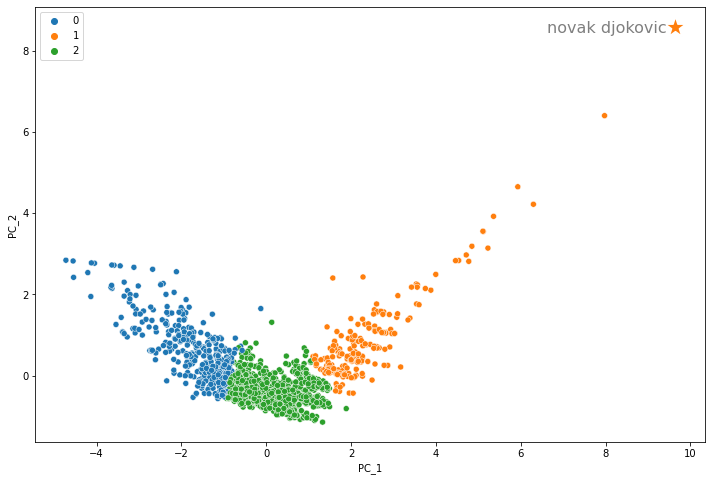

In [ ]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[0]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

In [ ]:
def plot_basic_statistics(df, labels, columns):
    df = pd.DataFrame(df, columns=columns)
    df['cluster'] = labels
    columns = df.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(14,8))
    for i in np.unique(df['cluster'].array):
        clust = df.loc[df['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    for i in np.unique(df['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=55)

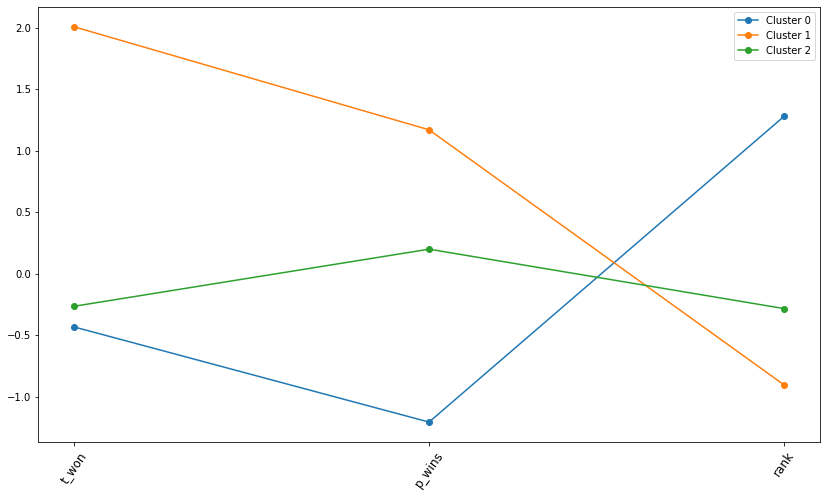

In [ ]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[0], clusters_players, df_clusters_scaled[0].columns)

From what we can see, cluster 1 contains the best players, meanwhile cluster 1 contains those with an high percentage of wins but less tourneys won (those are what are probably players from the top25 to top100 in the rankings), cluster 0 contains all the remaining players.

In [ ]:
df_clusters[0]["cluster"] = kmeans.labels_  # insert the column "cluster"
df_clusters[0].groupby("cluster").mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,t_won,p_wins,rank
cluster,,,
0,0.016000,28.985307,952.824000
1,5.014019,59.291589,94.373832
2,0.359050,46.913966,338.335312


The means we calculated for each clusters confirm our assumptions on the clusters (i.e.: cluster 1 contains the best current players).

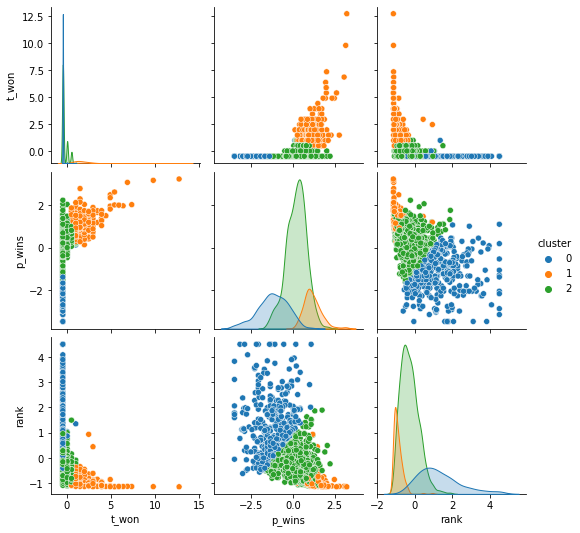

In [ ]:
sn.pairplot(df_clusters_scaled[0], hue='cluster', palette='tab10')
plt.show()

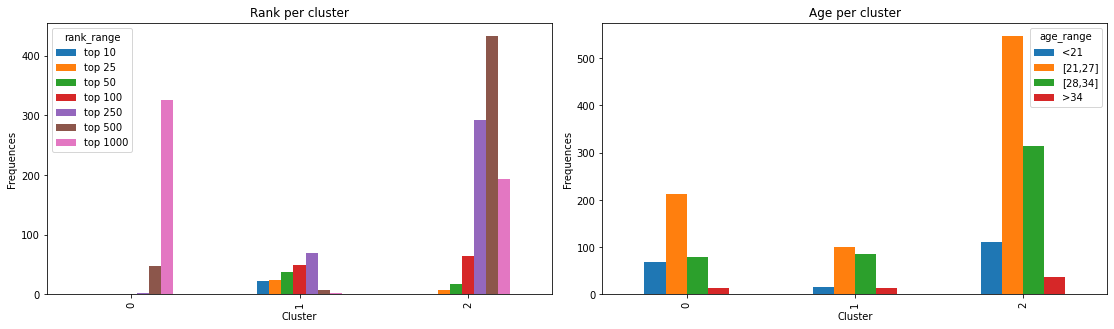

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

From the last two graphs we can see how the best players fall in the same cluster (labeled with 1) and they are mostly in the 21 to 27 age range (which is the usal peak for a tennis player).

### **Centroids**

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_centr = pd.DataFrame(centers, columns=df_clust_selected.columns)
df_centr

,mean_svPt,mean_bpFaced,mean_aces
0,62.932660,6.592593,2.144781
1,74.758197,5.528689,7.213115
2,71.082192,8.625571,1.406393
3,71.692432,6.526570,3.322061


Text(0.5, 0, 'mean_svPt')

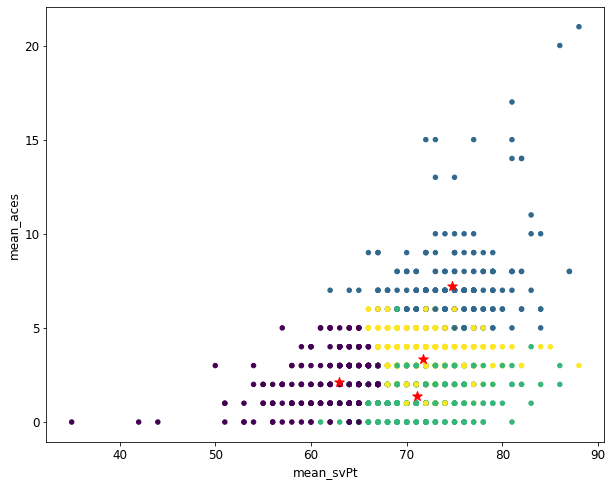

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
#fig, axs = plt.subplots(2,2,figsize=(15,15))

label_s = 12
feat1 = 'mean_svPt'
feat2 = 'mean_aces'
col1, i1 = df_clust_selected[feat1], df_clust_selected.columns.get_loc(feat1)
col2, i2 = df_clust_selected[feat2], df_clust_selected.columns.get_loc(feat2)
xlim = df_clust_selected[feat1].max()
ylim = df_clust_selected[feat2].max()
offsetx = df_clust_selected[feat1].max()/20
offsety = df_clust_selected[feat2].max()/20

fig = plt.figure(figsize=(10,8))

plt.scatter(col1, col2, c=kmeans.labels_, s=20)
plt.scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.ylabel(df_clust_selected.columns[i2], fontsize=label_s)
plt.xlabel(df_clust_selected.columns[i1], fontsize=label_s)

In [ ]:
df_clust_selected_stand

,mean_svPt,mean_bpFaced,mean_aces,cluster
0,2.010512,-1.447920,2.059344,1
1,-0.069369,0.028608,0.779586,3
2,-0.258449,0.028608,-0.073586,3
3,2.766833,0.766872,0.353000,3
4,-1.771090,-1.447920,0.779586,0
...,...,...,...,...
1595,0.497871,-1.447920,4.192273,1
1596,-1.392929,0.028608,0.353000,0
1597,0.119711,-0.709656,0.779586,3
1598,-0.636609,-0.709656,0.353000,3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


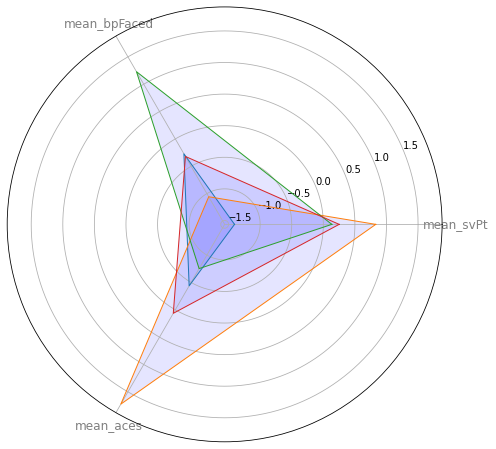

In [ ]:
from math import pi

centers = kmeans.cluster_centers_
# number of variable
N = len(df_clust_selected_stand.columns) - 1

plt.figure(figsize = (8,8))
label_s = 12

for i in range(0,len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], df_clust_selected_stand.columns, color='grey', size=label_s) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
# Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

In [ ]:
df_clust

,Cluster ID
name,
alexander zverev,0
frank moser,2
ruben ramirez hidalgo,3
tommy haas,4
toshihide matsui,3
...,...
sam groth,2
alexandar lazov,3
david o hare,1


In [ ]:
df_clust.loc['roger federer']

Cluster ID    0
Name: roger federer, dtype: int32

# DB-scan

In [ ]:
dist = pdist(X=X, metric='euclidean')  # pair-wise distance: how every record is far from all others
dist = squareform(dist)                # distance matrix given the vector dist

In [ ]:
kmin, kmax = 3, 30
kth_distances = {k:[] for k in range(kmin, kmax + 1)} # initialize k lists

for d in dist:
    # argsort returns the indexes that would sort d
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        # append to kth_distances[k] the value in d that corresponds
        # to the distance of the i-th point (record) from its k-th nn.
        # it's like: kth_distances[k].append(sorted_d[k])), but we get "sorted_d[k]" by d[indexes_to_sort_d[k]]
        kth_distances[k].append(d[indexes_to_sort_d[k]])

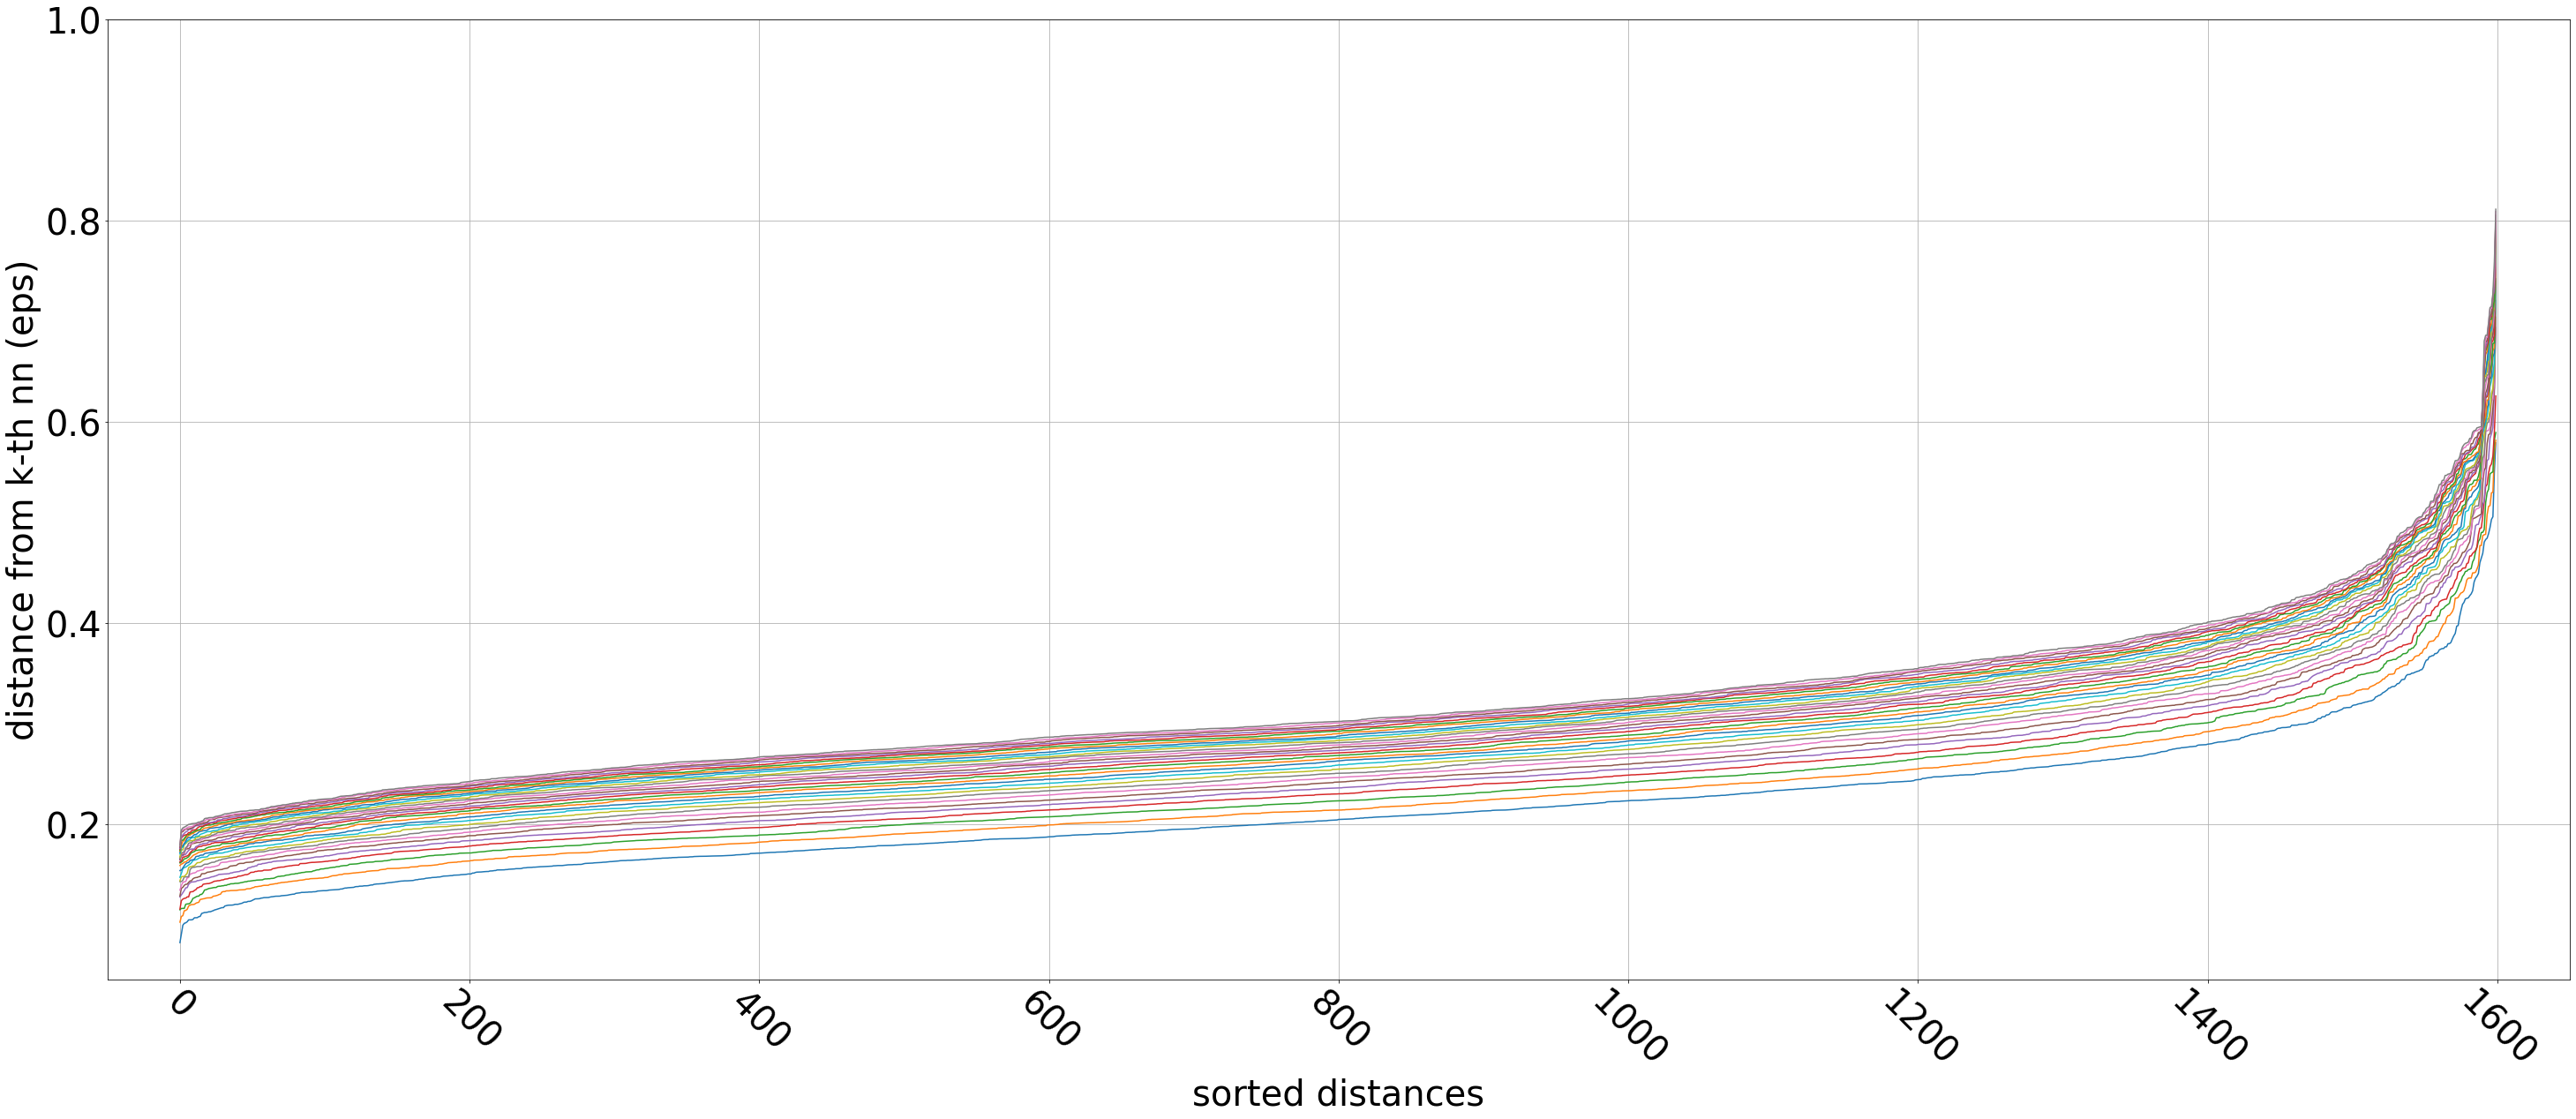

In [ ]:
plt.figure(figsize=(50, 20))
for k in kth_distances.keys():
    plt.plot(range(0, len(kth_distances[k])), sorted(kth_distances[k]))
plt.xlim((-50, len(X) + 50))
plt.ylim(top=1)
plt.ylabel('distance from k-th nn (eps)', fontsize=40)
plt.xlabel('sorted distances', fontsize=40)
plt.xticks(rotation=-45, fontsize=40)
plt.yticks(fontsize=40)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(range(0,len(kth_distances[kmin])), kmedian, linewidth=1) #kmedian already sorted
plt.ylabel('Median of the k-th nn distances (eps)', fontsize=15)
plt.xlabel('Indexes of the list of the sorted pairwise distances', fontsize=15)
xticks = []

for i in range(0, len(X)-1000, 200): xticks.append(i)

for i in range(4000, len(kth_distances[kmin]), 100): xticks.append(i)

plt.xticks(xticks, rotation=-45, fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='both', which='major')
plt.xlim((3800, 4400))
plt.ylim(top=1)
plt.grid()
low_elb = 4000
high_elb = 4200
plt.axvline(x=low_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[low_elb], color='red', linestyle='--', linewidth=1)
plt.axvline(x=high_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[high_elb], color='red', linestyle='--', linewidth=1)
plt.show()
print("Elbow area of the median of kth-NN distances plot:")
print(f"Low:\tx = {low_elb} --> eps = {kmedian[low_elb]}")  # kmedian is already sorted
print(f"High:\tx = {high_elb} --> eps = {kmedian[high_elb]}")  # kmedian is already sorted